# Building a Basic MNIST Neural Network from Scratch

Within this notebook, I've created a straightforward two-layer neural network and conducted training using the MNIST digit recognizer mnistset. This serves as an educational illustration, providing insights into the fundamental mathematics behind neural networks.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt


In [2]:

mnist = pd.read_csv('Abdu/train.csv')
mnist = np.array(mnist)
m, n = mnist.shape
np.random.shuffle(mnist) # shuffle before splitting into validation and training sets

In [3]:
mnist_validation = mnist[0:1500].T
Y_validation = mnist_validation[0]
X_validation = mnist_validation[1:n]
X_validation = X_validation / 255.

In [4]:
mnist_train = mnist[1500:m].T
Y_train = mnist_train[0]
X_train = mnist_train[1:n]
X_train = X_train / 255.
_,m_train = X_train.shape

In [5]:
Y_train

array([3, 1, 7, ..., 4, 1, 1], dtype=int64)

Our NN will have a simple two-layer architecture. Input layer $a^{[0]}$ will have 784 units corresponding to the 784 pixels in each 28x28 input image. A hidden layer $a^{[1]}$ will have 10 units with ReLU activation, and finally our output layer $a^{[2]}$ will have 10 units corresponding to the ten digit classes with softmax activation.

**Forward propagation**

$$Z^{[1]} = W^{[1]} X + b^{[1]}$$
$$A^{[1]} = g_{\text{ReLU}}(Z^{[1]}))$$
$$Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}$$
$$A^{[2]} = g_{\text{softmax}}(Z^{[2]})$$

**Backward propagation**

$$dZ^{[2]} = A^{[2]} - Y$$
$$dW^{[2]} = \frac{1}{m} dZ^{[2]} A^{[1]T}$$
$$dB^{[2]} = \frac{1}{m} \Sigma {dZ^{[2]}}$$
$$dZ^{[1]} = W^{[2]T} dZ^{[2]} .* g^{[1]\prime} (z^{[1]})$$
$$dW^{[1]} = \frac{1}{m} dZ^{[1]} A^{[0]T}$$
$$dB^{[1]} = \frac{1}{m} \Sigma {dZ^{[1]}}$$

**Parameter updates**

$$W^{[2]} := W^{[2]} - \alpha dW^{[2]}$$
$$b^{[2]} := b^{[2]} - \alpha db^{[2]}$$
$$W^{[1]} := W^{[1]} - \alpha dW^{[1]}$$
$$b^{[1]} := b^{[1]} - \alpha db^{[1]}$$

**Vars and shapes**

Forward prop

- $A^{[0]} = X$: 784 x m
- $Z^{[1]} \sim A^{[1]}$: 10 x m
- $W^{[1]}$: 10 x 784 (as $W^{[1]} A^{[0]} \sim Z^{[1]}$)
- $B^{[1]}$: 10 x 1
- $Z^{[2]} \sim A^{[2]}$: 10 x m
- $W^{[1]}$: 10 x 10 (as $W^{[2]} A^{[1]} \sim Z^{[2]}$)
- $B^{[2]}$: 10 x 1

Backprop

- $dZ^{[2]}$: 10 x m ($~A^{[2]}$)
- $dW^{[2]}$: 10 x 10
- $dB^{[2]}$: 10 x 1
- $dZ^{[1]}$: 10 x m ($~A^{[1]}$)
- $dW^{[1]}$: 10 x 10
- $dB^{[1]}$: 10 x 1

In [6]:
def init_params():
    W1 = np.random.rand(10, 784) - 0.5
    b1 = np.random.rand(10, 1) - 0.5
    W2 = np.random.rand(10, 10) - 0.5
    b2 = np.random.rand(10, 1) - 0.5
    return W1, b1, W2, b2

def ReLU(Z):
    return np.maximum(Z, 0)

def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A
    
def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

def ReLU_deriv(Z):
    return Z > 0

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2)
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1)
    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1    
    W2 = W2 - alpha * dW2  
    b2 = b2 - alpha * db2    
    return W1, b1, W2, b2

In [7]:
def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    print(predictions, Y)
    return np.sum(predictions == Y) / Y.size

def gradient_descent(X, Y, iterations, alpha):
    W1, b1, W2, b2 = init_params()
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        if i % 10 == 0:
            print("Iteration: ", i)
            predictions = get_predictions(A2)
            print(get_accuracy(predictions, Y))
    return W1, b1, W2, b2

In [18]:
W1, b1, W2, b2 = gradient_descent(X_train, Y_train, 600, 0.1)

Iteration:  0
[6 6 8 ... 6 6 3] [3 1 7 ... 4 1 1]
0.08760493827160494
Iteration:  10
[2 6 8 ... 5 2 3] [3 1 7 ... 4 1 1]
0.2034074074074074
Iteration:  20
[2 1 7 ... 5 2 3] [3 1 7 ... 4 1 1]
0.29145679012345677
Iteration:  30
[2 1 7 ... 4 2 3] [3 1 7 ... 4 1 1]
0.3653827160493827
Iteration:  40
[1 1 7 ... 4 2 3] [3 1 7 ... 4 1 1]
0.44237037037037036
Iteration:  50
[1 1 7 ... 4 1 3] [3 1 7 ... 4 1 1]
0.5019753086419753
Iteration:  60
[3 1 7 ... 4 1 3] [3 1 7 ... 4 1 1]
0.5427654320987654
Iteration:  70
[3 1 7 ... 4 1 2] [3 1 7 ... 4 1 1]
0.5731111111111111
Iteration:  80
[3 1 7 ... 4 1 2] [3 1 7 ... 4 1 1]
0.5972592592592593
Iteration:  90
[3 1 7 ... 4 1 2] [3 1 7 ... 4 1 1]
0.6211604938271605
Iteration:  100
[3 1 7 ... 4 1 2] [3 1 7 ... 4 1 1]
0.6405925925925926
Iteration:  110
[3 1 7 ... 4 1 2] [3 1 7 ... 4 1 1]
0.6569876543209876
Iteration:  120
[3 1 7 ... 4 1 2] [3 1 7 ... 4 1 1]
0.6725679012345679
Iteration:  130
[3 1 7 ... 4 1 2] [3 1 7 ... 4 1 1]
0.6869135802469136
Iteration:  14

#### YAAAAAAAAAAY 86% 

In [16]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

def test_prediction(index, W1, b1, W2, b2):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Let's look at a couple of examples:

Prediction:  [1]
Label:  1


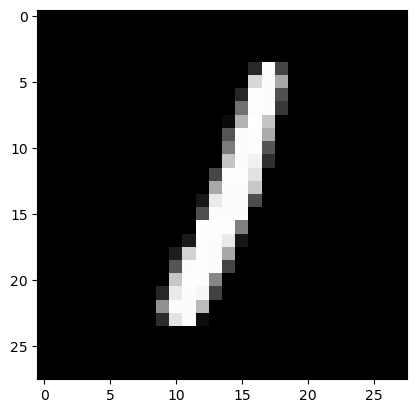

In [19]:
test_prediction(11, W1, b1, W2, b2)

Prediction:  [7]
Label:  7


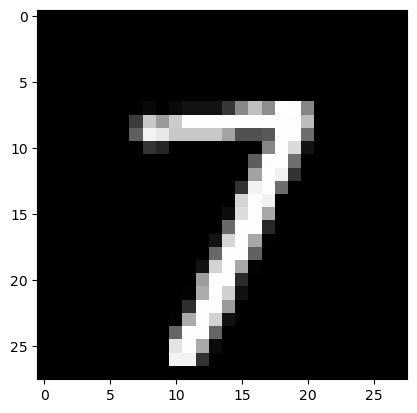

In [20]:
test_prediction(2, W1, b1, W2, b2)

Prediction:  [3]
Label:  3


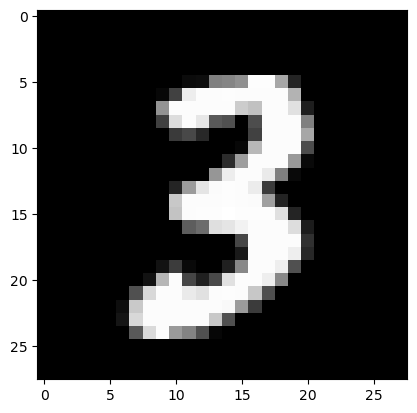

In [22]:
test_prediction(98, W1, b1, W2, b2)

Prediction:  [9]
Label:  9


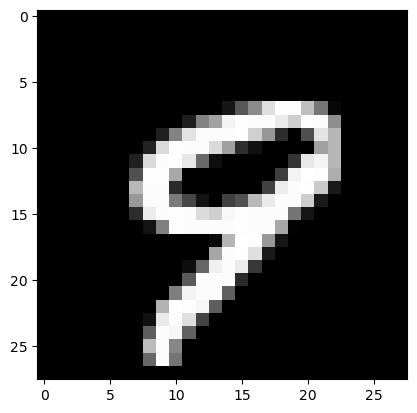

In [24]:
test_prediction(49, W1, b1, W2, b2)

Finally, let's find the accuracy on the validation set:

In [25]:
validation_predictions = make_predictions(X_validation, W1, b1, W2, b2)
get_accuracy(validation_predictions, Y_validation)

[6 9 2 ... 3 7 5] [6 9 2 ... 3 9 5]


0.8466666666666667

#### 84.6% accuracy 

## Model Conclusion:

The from-scratch implemented neural network achieved an accuracy of 84.6% on the validation set. While this indicates successful learning, there is room for improvement through hyperparameter tuning and further analysis of misclassifications. The model demonstrates promising generalization to unseen data, highlighting its robustness. Future steps include fine-tuning, evaluating on a test set, and deeper analysis for enhanced performance.